In [2]:
# General Imports

import numpy as np
from PIL import Image
from astropy import nddata
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
%matplotlib inline
from jax.random import PRNGKey # Need to use a seed to start jax's random number generation

In [4]:
# Opening Image
img = 'rsb_fits_images/test0.fits'

# Acquiring Image, PSF, Variance
uncertainty_data = hdu[3].data    # variance
img_data = hdu[1].data            # image

psfex_hdu_data_index = 10
psfex_hdu_info_index = 9 
hdu = fits.open(img)

# Acquiring Workable PSF
psfex_info = hdu[psfex_hdu_info_index]
psfex_data = hdu[psfex_hdu_data_index]

pixstep = psfex_info.data._pixstep[0]  # Image pixel per PSF pixel
size = psfex_data.data["_size"]  # size of PSF  (nx, ny, n_basis_vectors)
comp = psfex_data.data["_comp"]  # PSF basis components
coeff = psfex_data.data["coeff"]  # Coefficients modifying each basis vector
psf_basis_image = comp[0].reshape(*size[0][::-1])
psf_image = psf_basis_image * psfex_data.data["basis"][0, :, np.newaxis, np.newaxis]
psf_image = psf_image.sum(0)
psf_image /= psf_image.sum() * pixstep**2

# Plotting PSF
# plt.imshow(psf_image, cmap='gray', interpolation='none',vmin=-0.0001, vmax=0.0001)
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.show()

# PLotting Retrieved FITS Image
# plt.imshow(img_data.data, vmin=0, vmax=0.3,origin="lower", cmap="gray")
# plt.title('Original Image Array')
# plt.show()

In [6]:
def gen_mask(image_shape):
    import jax.numpy as jnp
    return jnp.array(np.zeros(image_shape))

def gen_psf(image_shape):
    psf = np.zeros(image_shape)
    center = (image_shape[0] // 2, image_shape[1] // 2)
    psf[center] = 1
    sigma = 2  
    psf = gaussian_filter(psf, sigma=sigma)
    psf /= psf.sum()
    return psf

def resize_psf(psf_image, new_shape):
    import cv2
    resized_psf = cv2.resize(psf_image, new_shape, interpolation=cv2.INTER_AREA)
    resized_psf /= np.sum(resized_psf)    
    return resized_psf

In [8]:
# Defining Threshold in Relation to Background RMS (how bright a source must be)
from photutils.background import Background2D, MedianBackground
bkg_estimator = MedianBackground()
bkg = Background2D(img_data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
threshold = 1.9 * bkg.background_rms 


from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.0
convolved_data = convolve(img_data, kernel)


# Detecting Sources --> Segmentation Map
from photutils.segmentation import detect_sources
from matplotlib.colors import LogNorm
segment_map = detect_sources(convolved_data, threshold, npixels=10)


segment_map.remove_border_labels(10, partial_overlap=False, relabel=False)
bbox = segment_map.bbox
shortened_bbox = bbox[10:len(bbox):30]

# Creating Same-Dimension Cutouts of Image, Mask, and Variance
cutouts = []
for i in range(len(shortened_bbox)):
    y_center, x_center = shortened_bbox[i].center
    x_len,y_len = shortened_bbox[i].shape
    min_length = 12 #22
    if (x_len> 10 and y_len > 10 and x_len < 40 and y_len < 40):
        length = max([x_len, y_len, min_length]) * 1.25
        my_cutout = nddata.Cutout2D(img_data, (x_center,y_center), int(length))
        cutout_mask = gen_mask(my_cutout.shape)
        # generated_psf = gen_psf(my_cutout.shape)
        # normalized_psf = generated_psf/np.sum(generated_psf)
        actual_psf = resize_psf(psf_image, my_cutout.shape)
        cutout_var = nddata.Cutout2D(uncertainty_data, (x_center,y_center), int(length))
        package = [my_cutout, cutout_mask, cutout_var, actual_psf] #normalized_psf,actual_psf]
        cutouts.append(package)

  3%|▎         | 251/10000 [00:00<00:03, 2814.19it/s, Round = 2,step_size = 1.0e-04 loss: 2.167e+05]


600.0566

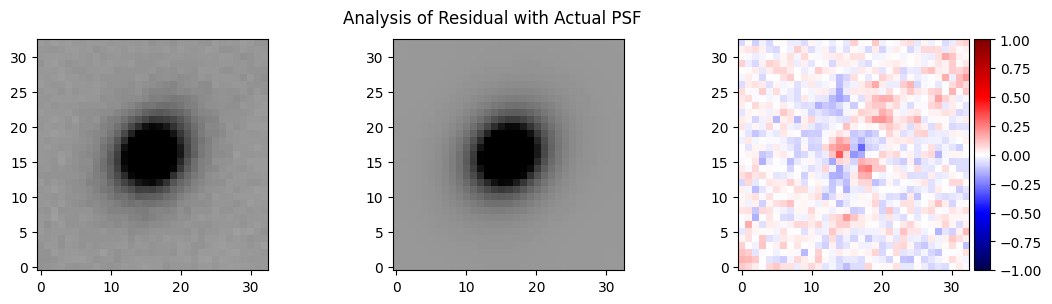

In [20]:
# Fitting a Sersic Profile
from pysersic import FitSingle
from pysersic.loss import student_t_loss
from pysersic import results
from pysersic.priors import autoprior
from pysersic.priors import SourceProperties
from pysersic import check_input_data
from pysersic import FitSingle
from pysersic.loss import gaussian_loss
from pysersic.results import plot_residual

# for i in range(1):
im,mask,sig,psf = cutouts[i] # image, mask, variance, psf

# Plotting Cutout & PSF
# fig, axes = plt.subplots(1, 2, figsize=(12, 12))
#     axes[0].imshow(im.data, cmap='gray', origin="lower")
#     axes[0].set_title('Cutout')
#     axes[0].axis('off')

#     axes[1].imshow(actual_psf, cmap='gray',origin="lower")
#     axes[1].set_title('PSF')
#     axes[1].axis('off')
#     plt.imshow(actual_psf, cmap='gray', origin="lower",vmin=-0.0001,vmax=0.005)#,interpolation='none')

#     plt.tight_layout()
#     plt.subplots_adjust(wspace=0.3)
#     plt.show()
# Sersic Fitting
# prior = autoprior(image = im.data, profile_type = 'sersic', mask=mask, sky_type = 'none')
props = SourceProperties(im.data,mask=mask) # Optional mask
prior = props.generate_prior('sersic',sky_type='none') # Can also use 'flat' or 'tilted-plane' to simultaneously fit a background
check_input_data(im.data, sig.data, psf, mask)
fitter = FitSingle(data=im.data,rms=sig.data, psf=psf, prior=prior, mask=mask, loss_func=gaussian_loss) 
map_params = fitter.find_MAP(rkey = PRNGKey(1000));
fig, ax = plot_residual(im.data,map_params['model'],mask=mask,vmin=-1,vmax=1);
fig.suptitle("Analysis of Residual with Actual PSF")

# Computing Chi-Square Statistic
# sum of (actual brightness - model brightness)/model brightness

image = im.data
model = map_params['model']

np.sum(image)
np.sum(model)

#     assert(image.shape == model.shape)
#     chi_squared = np.sum((image-model)**2/model)
#     print(chi_squared)
#     from scipy.stats import chisquare

#     print(chisquare(f_obs=image, f_exp=model))

# for i in map_params.keys():
#     print(i + ": " + str(map_params[i]))
    
# fitter = FitSingle(data=im.data,rms=sig.data,mask=mask,psf=normalized_psf,prior=prior,loss_func=student_t_loss)

In [66]:
# Chi-squared Statistic --> Evaluating Whether the difference in Image and Model is systematic or due to noise
# Check if p value is less than variance
from scipy.stats import chi2
chi_square = np.sum((image*2.2 - model) ** 2 / (model))
df = image.size-1 # number of independent categories ? --> measuring the count of photons at each pixel (are they independent though??)
p_value = chi2.sf(chi_square, df)

In [89]:
# L1-Norm Statistic/Manhatten Distance --> Finding the Distance of the Difference Between Image and Model
# sum of absolute value of (actual pixel value - model pixel value) for all pixels
# Source: https://medium.com/swlh/different-types-of-distances-used-in-machine-learning-ec7087616442#:~:text=L1%20Norm%3A,the%20components%20of%20the%20vectors.

image_1D = image.flatten()
model_1D = model.flatten()
difference_1D = image_1D - model_1D
l1 = np.sum(np.abs(difference_1D))
l1_normalized = l1/(image_1D.size)

# what threshold should the l1_normalized metric meet?

In [40]:
# props = SourceProperties(im.data,mask=mask) # Optional mask
# prior = props.generate_prior('sersic',sky_type='none') # Can also use 'flat' or 'tilted-plane' to simultaneously fit a background
# check_input_data(im.data, sig.data, normalized_psf, mask)
# fitter = FitSingle(data=im.data,rms=sig.data, psf=normalized_psf, prior=prior, mask=mask, loss_func=gaussian_loss) 
# map_params = fitter.find_MAP(rkey = PRNGKey(1000))
# fig, ax = plot_residual(im.data,map_params['model'],mask=mask,vmin=-1,vmax=1)